## Is It a Car or a Motorcycle: Image Classification

Dataset Source: https://www.kaggle.com/datasets/utkarshsaxenadn/car-vs-bike-classification-dataset

##### Install Necessary Libraries Not Already Installed

In [1]:
### %pip install datasets transformers tensorboard evaluate

##### Import Necessary Libraries

In [2]:
import os, sys, random
os.environ['TOKENIZERS_PARALLELISM']='false'

from PIL import ImageDraw, ImageFont, Image
import PIL.Image

from tqdm import tqdm

import numpy as np
import pandas as pd

import datasets
from datasets import load_dataset, Image, load_metric, DatasetDict, Dataset

import transformers
from transformers import Trainer, TrainingArguments
from transformers import ViTForImageClassification, ViTFeatureExtractor

import torch

import evaluate

NOTE: Redirects are currently not supported in Windows or MacOs.


##### Display Versions of Relevant Libraries

In [3]:
print("Python:".rjust(15), sys.version[0:6])
print("NumPy:".rjust(15), np.__version__)
print("Pandas:".rjust(15), pd.__version__)
print("Datasets:".rjust(15), datasets.__version__)
print("Transformers:".rjust(15), transformers.__version__)
print("Torch:".rjust(15), torch.__version__)

        Python: 3.9.12
         NumPy: 1.23.3
        Pandas: 1.5.0
      Datasets: 2.5.2
  Transformers: 4.22.2
         Torch: 1.12.1


##### Ingest Dataset

In [4]:
dataset = load_dataset("imagefolder", 
                        data_dir="/Users/briandunn/Desktop/Vit Image Datasets/Car or Motorcycle", 
                        split='train',
                        drop_labels=False)

A Jupyter Widget

Using custom data configuration default-71f007a50cc9fc7a
Found cached dataset imagefolder (/Users/briandunn/.cache/huggingface/datasets/imagefolder/default-71f007a50cc9fc7a/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


##### Split Dataset into Training & Testing Datasets

In [5]:
dataset = dataset.shuffle(seed=42)

train_split = dataset.train_test_split(train_size=0.80)

ds = DatasetDict({
    'train' : train_split['train'],
    'test' : train_split['test']
})

Loading cached shuffled indices for dataset at /Users/briandunn/.cache/huggingface/datasets/imagefolder/default-71f007a50cc9fc7a/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f/cache-9ea2a2ae432b04fb.arrow


##### Some Information About Train & Test Datasets

In [6]:
print("Training Dataset")
print(ds['train'])
print(ds['train'][0])
print(ds['train'][-1])
print(ds['train'].unique("label"))

print("Testing Dataset")
print(ds['test'])
print(ds['test'][0])
print(ds['test'][-1])
print(ds['test'].unique("label"))

Training Dataset
Dataset({
    features: ['image', 'label'],
    num_rows: 3200
})
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=299x168 at 0x7F90343F1A60>, 'label': 1}
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=275x183 at 0x7F90343EBC70>, 'label': 1}


A Jupyter Widget

[1, 0]
Testing Dataset
Dataset({
    features: ['image', 'label'],
    num_rows: 800
})
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=180x132 at 0x7F90343F53A0>, 'label': 0}
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=299x168 at 0x7F90343F5A00>, 'label': 1}


A Jupyter Widget

[0, 1]


##### Display Grid of Examples From Each Class to Gain Better Picture of Data

In [7]:
def show_grid_of_examples(ds, 
                          seed: int = 42, 
                          examples_per_class: int = 3, 
                          size=(350, 350)):
    '''
    This function displays a few pictures
    from each class in the dataset.
    '''
    w, h = size
    labels = ds.features['label'].names
    grid = PIL.Image.new(mode='RGB', size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)
    font = ImageFont.truetype("Chalkduster.ttf", 24)
    
    for label_id, label in enumerate(labels):
        # filter the dataset by a single label, shuffle it, then grab a few samples
        ds_slice = ds \
                    .filter(lambda ex: ex['label'] == label_id) \
                    .shuffle(seed) \
                    .select(range(examples_per_class))
        
        # plot this label's examples in a row
        for i, example in enumerate(ds_slice):
            image = example['image']
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box=box)
            draw.text(box, label, (255, 255, 255), font=font)
    
    return grid

Loading cached processed dataset at /Users/briandunn/.cache/huggingface/datasets/imagefolder/default-71f007a50cc9fc7a/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f/cache-592f22bae327aa3a.arrow
Loading cached shuffled indices for dataset at /Users/briandunn/.cache/huggingface/datasets/imagefolder/default-71f007a50cc9fc7a/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f/cache-b23b21825ab407b1.arrow
Loading cached processed dataset at /Users/briandunn/.cache/huggingface/datasets/imagefolder/default-71f007a50cc9fc7a/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f/cache-fb37c81a2f0c2012.arrow
Loading cached shuffled indices for dataset at /Users/briandunn/.cache/huggingface/datasets/imagefolder/default-71f007a50cc9fc7a/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f/cache-f392a7c726f29da7.arrow


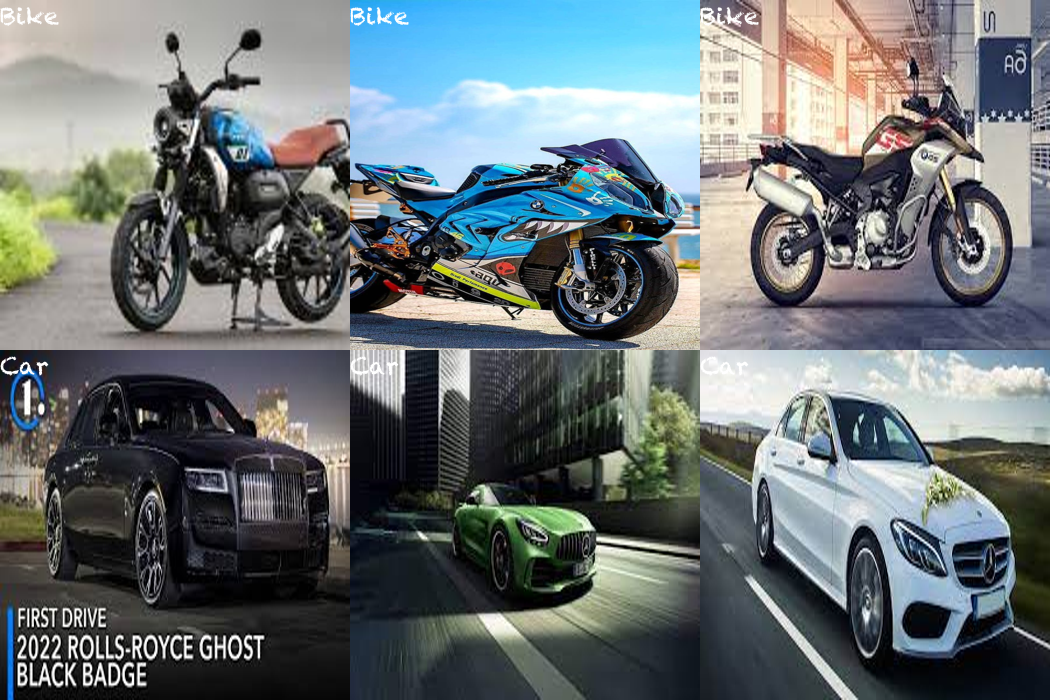

In [8]:
show_grid_of_examples(dataset, seed=42, examples_per_class=3)

##### Remember to Install git lfs & Enter HuggingFace Access Token

In [9]:
# Enter Huggingface Access Token

!git lfs install

Git LFS initialized.


##### Basic Values/Constants

In [10]:
MODEL_CKPT='google/vit-base-patch16-224-in21k'
NUM_OF_EPOCHS=2

LEARNING_RATE=2e-4
STEPS=100

BATCH_SIZE=16
DEVICE = torch.device("mps")

REPORTS_TO='tensorboard'

##### Load ViT Feature Extractor

In [11]:
feature_extractor = ViTFeatureExtractor.from_pretrained(MODEL_CKPT)

##### Preprocessing Dataset

In [12]:
def transform(sample_batch):
    # take a list of PIL images and turn them into pixel values
    inputs = feature_extractor([x.convert("RGB") for x in sample_batch['image']], return_tensors="pt")
    
    # prepare labels
    inputs['labels'] = sample_batch['label']
    return inputs

##### Apply Transform Function to Dataset

In [13]:
prepped_ds = ds.with_transform(transform)

#### Training & Evaluation

##### Define Data Collator

In [14]:
def data_collator(batch):
    return {
        'pixel_values' : torch.stack([x['pixel_values'] for x in batch]),
        'labels' : torch.tensor([x['labels'] for x in batch])
    }

##### Define Evaluation Metric

In [15]:
def compute_metrics(p):
    accuracy_metric = evaluate.load("accuracy")
    accuracy = accuracy_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)['accuracy']
    
    ### ------------------- F1 scores -------------------
    
    f1_score_metric = evaluate.load("f1")
    f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)["f1"]
    
    ### ------------------- recall -------------------
    
    recall_metric = evaluate.load("recall")
    recall = recall_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)["recall"]
    
    ### ------------------- precision -------------------
    
    precision_metric = evaluate.load("precision")
    precision = precision_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)["precision"]
    
    return {"accuracy" : accuracy, 
            "Weighted F1" : f1_score,
            "Weighted Recall" : recall,
            "Weighted Precision" : precision,
            }

##### Load Pretrained Model

In [16]:
labels = ds['train'].features['label'].names

model = ViTForImageClassification.from_pretrained(
    MODEL_CKPT,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
).to(DEVICE)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


##### Define Training Arguments

In [17]:
args = TrainingArguments(
    output_dir=MODEL_CKPT + "_car_or_motorcycle",
    remove_unused_columns=False,
    num_train_epochs=NUM_OF_EPOCHS,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    report_to=REPORTS_TO,
    disable_tqdm=False,
    load_best_model_at_end=True,
    logging_first_step=True,
    push_to_hub=True
)

##### Instantiate Trainer

In [18]:
trainer = Trainer(
    model = model,
    args= args,
    data_collator = data_collator,
    compute_metrics = compute_metrics,
    train_dataset=prepped_ds['train'],
    eval_dataset=prepped_ds['test'],
    tokenizer=feature_extractor,
)

Cloning https://huggingface.co/DunnBC22/vit-base-patch16-224-in21k_car_or_motorcycle into local empty directory.


##### Train Model

In [19]:
train_results = trainer.train()

/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3200
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 400


A Jupyter Widget

{'loss': 0.6908, 'learning_rate': 0.00019950000000000002, 'epoch': 0.01}


/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
***** Running Evaluation *****
  Num examples = 800
  Batch size = 8


A Jupyter Widget

Saving model checkpoint to google/vit-base-patch16-224-in21k_car_or_motorcycle/checkpoint-200
Configuration saved in google/vit-base-patch16-224-in21k_car_or_motorcycle/checkpoint-200/config.json
Model weights saved in google/vit-base-patch16-224-in21k_car_or_motorcycle/checkpoint-200/pytorch_model.bin
Feature extractor saved in google/vit-base-patch16-224-in21k_car_or_motorcycle/checkpoint-200/preprocessor_config.json


{'eval_loss': 0.037172459065914154, 'eval_accuracy': 0.99, 'eval_Weighted F1': 0.9902200488997555, 'eval_Weighted Recall': 0.9902200488997555, 'eval_Weighted Precision': 0.9902200488997555, 'eval_runtime': 719.5993, 'eval_samples_per_second': 1.112, 'eval_steps_per_second': 0.139, 'epoch': 1.0}


Feature extractor saved in google/vit-base-patch16-224-in21k_car_or_motorcycle/preprocessor_config.json
/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
***** Running Evaluation *****
  Num examples = 800
  Batch size = 8


A Jupyter Widget

Saving model checkpoint to google/vit-base-patch16-224-in21k_car_or_motorcycle/checkpoint-400
Configuration saved in google/vit-base-patch16-224-in21k_car_or_motorcycle/checkpoint-400/config.json
Model weights saved in google/vit-base-patch16-224-in21k_car_or_motorcycle/checkpoint-400/pytorch_model.bin
Feature extractor saved in google/vit-base-patch16-224-in21k_car_or_motorcycle/checkpoint-400/preprocessor_config.json


{'eval_loss': 0.03013431467115879, 'eval_accuracy': 0.99375, 'eval_Weighted F1': 0.9938800489596084, 'eval_Weighted Recall': 0.9926650366748166, 'eval_Weighted Precision': 0.9950980392156863, 'eval_runtime': 725.1047, 'eval_samples_per_second': 1.103, 'eval_steps_per_second': 0.138, 'epoch': 2.0}


Feature extractor saved in google/vit-base-patch16-224-in21k_car_or_motorcycle/preprocessor_config.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from google/vit-base-patch16-224-in21k_car_or_motorcycle/checkpoint-400 (score: 0.03013431467115879).


{'train_runtime': 18560.3453, 'train_samples_per_second': 0.345, 'train_steps_per_second': 0.022, 'train_loss': 0.03386496916413307, 'epoch': 2.0}


In [20]:
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Saving model checkpoint to google/vit-base-patch16-224-in21k_car_or_motorcycle
Configuration saved in google/vit-base-patch16-224-in21k_car_or_motorcycle/config.json
Model weights saved in google/vit-base-patch16-224-in21k_car_or_motorcycle/pytorch_model.bin
Feature extractor saved in google/vit-base-patch16-224-in21k_car_or_motorcycle/preprocessor_config.json
Saving model checkpoint to google/vit-base-patch16-224-in21k_car_or_motorcycle
Configuration saved in google/vit-base-patch16-224-in21k_car_or_motorcycle/config.json
Model weights saved in google/vit-base-patch16-224-in21k_car_or_motorcycle/pytorch_model.bin
Feature extractor saved in google/vit-base-patch16-224-in21k_car_or_motorcycle/preprocessor_config.json
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


A Jupyter Widget

A Jupyter Widget

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/DunnBC22/vit-base-patch16-224-in21k_car_or_motorcycle
   c4f4061..770d17d  main -> main

To https://huggingface.co/DunnBC22/vit-base-patch16-224-in21k_car_or_motorcycle
   770d17d..4225746  main -> main



***** train metrics *****
  epoch                    =        2.0
  train_loss               =     0.0339
  train_runtime            = 5:09:20.34
  train_samples_per_second =      0.345
  train_steps_per_second   =      0.022


##### Evaluate Model

In [21]:
metrics = trainer.evaluate(prepped_ds['test'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 800
  Batch size = 8


A Jupyter Widget

***** eval metrics *****
  epoch                   =        2.0
  eval_Weighted F1        =     0.9939
  eval_Weighted Precision =     0.9951
  eval_Weighted Recall    =     0.9927
  eval_accuracy           =     0.9938
  eval_loss               =     0.0301
  eval_runtime            = 0:12:11.31
  eval_samples_per_second =      1.094
  eval_steps_per_second   =      0.137


##### Push Model to Hub (My Profile!)

In [22]:
kwargs = {
    "finetuned_from" : model.config._name_or_path,
    "tasks" : "image-classification",
    "tags" : ["image-classification"],
}

if args.push_to_hub:
    trainer.push_to_hub("All Dunn!!!")
else:
    trainer.create_model_card(**kwargs)

Saving model checkpoint to google/vit-base-patch16-224-in21k_car_or_motorcycle
Configuration saved in google/vit-base-patch16-224-in21k_car_or_motorcycle/config.json
Model weights saved in google/vit-base-patch16-224-in21k_car_or_motorcycle/pytorch_model.bin
Feature extractor saved in google/vit-base-patch16-224-in21k_car_or_motorcycle/preprocessor_config.json


A Jupyter Widget

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/DunnBC22/vit-base-patch16-224-in21k_car_or_motorcycle
   4225746..5c642a2  main -> main



### Notes & Other Takeaways
****
- I am pleased with the results. Only 5 inferences were incorrect for the 800 images supplied.
****
- In this project, I updated to the new version of model evaluation. Additionally, this project also required a quick modificaton to remove the alpha channel on the image preprocessing.
****